<a href="https://colab.research.google.com/github/Ashrafalaghbari/capstone_project/blob/main/DLSTM_univariate_model_single_step.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from datetime import datetime
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.layers import LSTM
#from deap import base, creator, tools, algorithms
from keras import regularizers
from math import sqrt
from matplotlib import pyplot
import matplotlib.pyplot as plt
import numpy as np
from numpy import concatenate
import random
import tensorflow as  tf

In [2]:
def parser(x):
	return datetime.strptime(x, '%Y%m%d')

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = np.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataset = np.insert(dataset,[0]*look_back,0)    
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back):
		a = dataset[i:(i+look_back)]
		dataX.append(a)
		dataY.append(dataset[i + look_back])
	dataY= np.array(dataY)        
	dataY = np.reshape(dataY,(dataY.shape[0],1))
	dataset = np.concatenate((dataX,dataY),axis=1)  
	return dataset[look_back:]


# compute RMSPE
def RMSPE(x,y):
	result=0
	for i in range(len(x)):
		result += ((x[i]-y[i])/x[i])**2
	result /= len(x)
	result = sqrt(result)
	result *= 100
	return result

# compute MAPE
def MAPE(x,y):
	result=0
	for i in range(len(x)):
		result += abs((x[i]-y[i])/x[i])
	result /= len(x)
	result *= 100
	return result

# compute wMAPE weighted absolute percentage error
def wMAPE(actual, predicted): 
    result_nom = 0
    result_deno = 0
    for i in range(len(actual)):
        result_nom +=  abs(actual[i] - predicted[i])
        result_deno +=  abs(actual[i]) 
    result = result_nom/result_deno
    return result *100

def SMAPE(actual, predicted): #adjusted MEAN ABSOLUTE PERCENTAGE ERROR (SMAPE)
    result = 0
    for i in range(len(actual)):
        result += abs(actual[i] - predicted[i])/(abs(actual[i]) + abs(predicted[i]))
    result = 2* result/ len(actual) 
    return result * 100

In [3]:
look_back=5
neurons= [ 4 ] 
n_epochs=18#953

#load dataset
series = read_csv('/content/drive/MyDrive/volve_production_data/model.csv', usecols=["BORE_OIL_VOL","DATEPRD"], header=0,parse_dates=[0],index_col=0, squeeze=True)
raw_values = series.values
# transform data to be stationary
diff = difference(raw_values, 1)


# create dataset x,y
dataset = diff.values
dataset = create_dataset(dataset,look_back)


# split into train and test sets
train_size = int(dataset.shape[0] * 0.8)
test_size = dataset.shape[0] - train_size
train, test = dataset[0:train_size], dataset[train_size:]


# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# #load dataset
# 	series = read_csv('https://raw.githubusercontent.com/DeepWolf90/DLSTM2/master/case_study_1(Chinese%20oil)/DLSTM/oil_production.csv', header=0,parse_dates=[0],index_col=0, squeeze=True,date_parser=parser)


In [4]:
train.shape, test.shape

((1470, 6), (368, 6))

In [ ]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
np.random.seed(12345)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

from keras import backend as K
tf.random.set_seed(1234)

sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

batch_size = 1
# fit the model


X, y = train_scaled[:, 0:-1], train_scaled[:, -1]
X = X.reshape(X.shape[0], X.shape[1],1 )

model = Sequential()
model.add(LSTM(neurons[0], batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
model.add(Dropout(0.3))
#model.add(LSTM(neurons[1], batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
#model.add(Dropout(0.3))
#model.add(LSTM(neurons[2], batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
#model.add(Dropout(0.3))
# model.add(LSTM(neurons[3], batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
# model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

for i in range(n_epochs):
    print('Epoch:',i)
    model.fit(X, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
    model.reset_states()


In [7]:
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, len(X), 1)
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

In [25]:
raw_values.shape

(1844,)

In [27]:
test_scaled.shape

(368, 6)

In [8]:
# forecast the test data
print('Forecasting Testing Data')
predictions_test = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions_test.append(yhat)
    expected = raw_values[len(train) + i + 1]
    print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

# report performance using RMSE
rmse_test = sqrt(mean_squared_error(raw_values[-len(test_scaled):], predictions_test))
print('Test RMSE: %.5f' % rmse_test)
#report performance using RMSPE
RMSPE_test = RMSPE(raw_values[-len(test_scaled):], predictions_test)
print('Test RMSPE: %.5f' % RMSPE_test)
MAE_test = mean_absolute_error(raw_values[-len(test_scaled):], predictions_test)
print('Test MAE: %.5f' % MAE_test)
MAPE_test = MAPE(raw_values[-len(test_scaled):], predictions_test)
print('Test MAPE: %.5f' % MAPE_test)
SMAPE_test = SMAPE(raw_values[-len(test_scaled):], predictions_test)
print('Test SMAPE: %.5f' % SMAPE_test)
wMAPE_test = wMAPE(raw_values[-len(test_scaled):], predictions_test)
print('Test wMAPE: %.5f ' % wMAPE_test)
r2 = r2_score(raw_values[-len(test_scaled):], predictions_test)
print('Test r2: %.5f' % r2)


Forecasting Testing Data
1/1 [==============================] - 0s 443ms/step
Month=1, Predicted=3485.027917, Expected=3388.195174
1/1 [==============================] - 0s 15ms/step
Month=2, Predicted=3416.592328, Expected=3407.504893
1/1 [==============================] - 0s 17ms/step
Month=3, Predicted=2335.785726, Expected=3366.558226
1/1 [==============================] - 0s 14ms/step
Month=4, Predicted=2826.540902, Expected=3390.836894
1/1 [==============================] - 0s 17ms/step
Month=5, Predicted=1310.923252, Expected=3443.734202
1/1 [==============================] - 0s 19ms/step
Month=6, Predicted=709.741914, Expected=3400.900591
1/1 [==============================] - 0s 15ms/step
Month=7, Predicted=2748.433517, Expected=1902.730605
1/1 [==============================] - 0s 15ms/step
Month=8, Predicted=1286.057382, Expected=2717.827160
1/1 [==============================] - 0s 15ms/step
Month=9, Predicted=2381.660679, Expected=672.443651
1/1 [==========================

<ipython-input-2-59d89d1fcfa6>:55: RuntimeWarning: divide by zero encountered in double_scalars
  result += ((x[i]-y[i])/x[i])**2
<ipython-input-2-59d89d1fcfa6>:65: RuntimeWarning: divide by zero encountered in double_scalars
  result += abs((x[i]-y[i])/x[i])


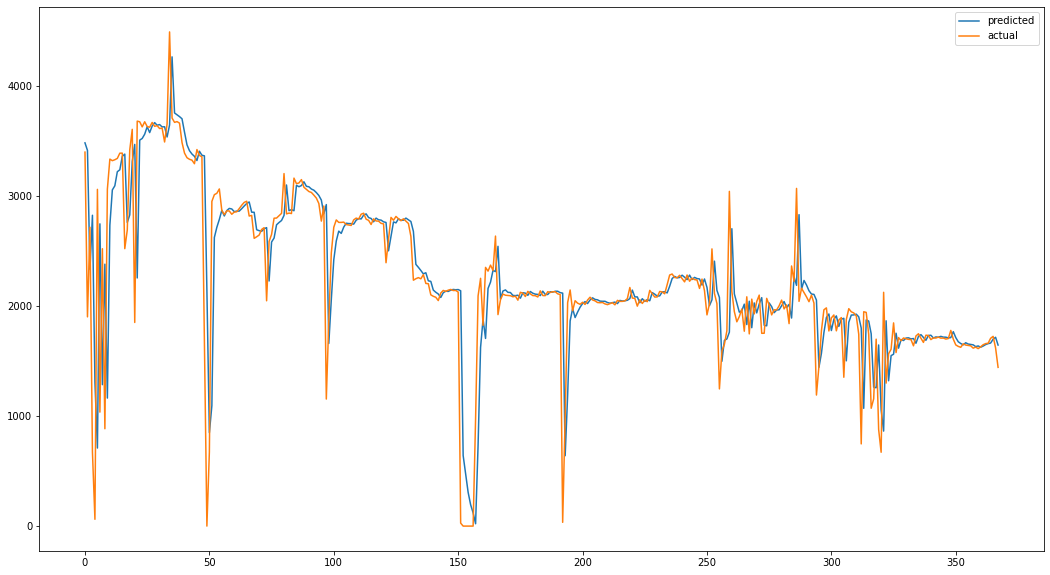

In [19]:
plt.figure(figsize=(18,10))
plt.plot(predictions_test, label = "predicted")
plt.plot(raw_values[-len(test_scaled):], label = "actual")
plt.legend()
plt.show()

In [10]:
concat([DataFrame(raw_values[-len(test_scaled):]), DataFrame(predictions_test)], axis=1).head(20)

,0,0
0,3400.900591,3485.027917
1,1902.730605,3416.592328
2,2717.827160,2335.785726
3,672.443651,2826.540902
4,61.703042,1310.923252
5,3062.131393,709.741914
6,1036.434991,2748.433517
7,2522.339847,1286.057382
8,885.227944,2381.660679
9,3063.892539,1164.145297


In [11]:
#@title Reported results
#univarite boreoil data with 1 diff
Test RMSE: 452.65617
Test RMSPE: inf
Test MAE: 206.28203
Test MAPE: inf
Test SMAPE: 14.11696
Test wMAPE: 9.20534 
Test r2: 0.60260
#univarite boreoil data with 1 diff without zero values
Test RMSE: 347.15236
Test RMSPE: 518.30341
Test MAE: 175.19431
Test MAPE: 47.68705
Test SMAPE: 9.01877
Test wMAPE: 7.69804 
Test r2: 0.70211
#univarite boreoil data with 2 diff
Test RMSE: 621.54569
Test RMSPE: inf
Test MAE: 307.28601
Test MAPE: inf
Test SMAPE: 20.03947
Test wMAPE: 13.69272 
Test r2: 0.25436


#dlstm original data with 18 epochs
Test RMSE: 0.26714
Test RMSPE: 3.79552
Test MAE: 0.19912
Test MAPE: 2.83966
Test SMAPE: 2.86086
Test wMAPE: 2.83630 
Test r2: 0.32087

SyntaxError: ignored